<a href="https://colab.research.google.com/github/MJung-Jo/Learning-Fuzzing/blob/main/FINAL_Fuzzer_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ◆ Library

In [ ]:
pip install fuzzingbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import List, Set, Dict, Sequence, cast, Any, Tuple, Union, Callable
import sqlparse
import sqlite3
import re
import time
import random

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from fuzzingbook.Coverage import Coverage
from fuzzingbook.Fuzzer import Fuzzer, Runner
from fuzzingbook.GreyboxFuzzer import Mutator, Seed, PowerSchedule, AdvancedMutationFuzzer
from fuzzingbook.Coverage import population_coverage

# ◆ Seed

Final Output : query

Extract only characters within `<code></code>`

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# Character extraction target URL
url = "https://www.sqlite.org/src/file?name=test/fts3e.test&ci=eddc05e7bb31fae7"

In [ ]:
def extract_Char(url: str) -> str:
    response = requests.get(url)
    html = response.text

    # HTML parsing
    soup = BeautifulSoup(html, 'html.parser')

    # Extract characters in <code></code>
    code_tag = soup.find('code')
    code_content = code_tag.get_text()

    # Check
    print(code_content)

    return code_content

In [ ]:
extract_char = extract_Char(url)

# 2008 July 29
#
# The author disclaims copyright to this source code.  In place of
# a legal notice, here is a blessing:
#
#    May you do good and not evil.
#    May you find forgiveness for yourself and forgive others.
#    May you share freely, never taking more than you give.
#
#*************************************************************************
# These tests exercise the various types of fts3 cursors.
#
# $Id: fts3e.test,v 1.1 2008/07/29 20:24:46 shess Exp $
#

set testdir [file dirname $argv0]
source $testdir/tester.tcl

# If SQLITE_ENABLE_FTS3 is not defined, omit this file.
ifcapable !fts3 {
  finish_test
  return
}

#*************************************************************************
# Test table scan (QUERY_GENERIC).  This kind of query happens for
# queries with no WHERE clause, or for WHERE clauses which cannot be
# satisfied by an index.
db eval {
  DROP TABLE IF EXISTS t1;
  CREATE VIRTUAL TABLE t1 USING fts3(c);
  INSERT INTO t1 (docid, c) VALUES (1, 'This i

Extract only the SQL code from the extracted characters

In [ ]:
def extract_SQLCode(extract_char) -> str:
    # Extract target pattern
    patterns = [
        # DML
        r"SELECT.*?;", r"INSERT INTO.*?;",
        r"UPDATE.*?;", r"DELETE.*?;",
        # DDL
        r"CREATE.*?;", r"ALTER.*?;",
        r"DROP.*?;", r"RENAME.*?;", r"TRUNCATE.*?;",
        # DCL
        r"GRANT.*?;", r"REVOKE.*?;",
    ]

    # Sort codes in the order they came in
    queries = []
    for pattern in patterns:
        queries.extend(re.finditer(pattern, extract_char, re.DOTALL))

    queries.sort(key=lambda x: x.start())

    ## Change to one string
    query = ""
    for match in queries:
        query = query + match.group() + '\n'

    # Test
    print(query)

    return query

In [ ]:
query = extract_SQLCode(extract_char)

DROP TABLE IF EXISTS t1;
CREATE VIRTUAL TABLE t1 USING fts3(c);
INSERT INTO t1 (docid, c) VALUES (1, 'This is a test');
INSERT INTO t1 (docid, c) VALUES (2, 'That was a test');
INSERT INTO t1 (docid, c) VALUES (3, 'This is a test');
SELECT docid FROM t1 ORDER BY docid;
SELECT docid FROM t1 WHERE c LIKE '%test' ORDER BY docid;
SELECT docid FROM t1 WHERE c LIKE 'That%' ORDER BY docid;
DROP TABLE IF EXISTS t1;
DROP TABLE IF EXISTS t2;
CREATE VIRTUAL TABLE t1 USING fts3(c);
CREATE TABLE t2(id INTEGER PRIMARY KEY AUTOINCREMENT, weight INTEGER UNIQUE);
INSERT INTO t2 VALUES (null, 10);
INSERT INTO t1 (docid, c) VALUES (last_insert_rowid(), 'This is a test');
INSERT INTO t2 VALUES (null, 5);
INSERT INTO t1 (docid, c) VALUES (last_insert_rowid(), 'That was a test');
INSERT INTO t2 VALUES (null, 20);
INSERT INTO t1 (docid, c) VALUES (last_insert_rowid(), 'This is a test');
SELECT docid FROM t1 WHERE docid in (1, 2, 10);
SELECT rowid FROM t1 WHERE rowid in (1, 2, 10);
SELECT docid, weight FROM t

# ◆ Target

Function : my_sql_parser

In [ ]:
def my_sql_parser(query: str) -> Any:
    parsed = sqlparse.parse(query, encoding=None)
    return parsed

# ◆ New Runner

class : sql_parser_Coverage_Runner


In [ ]:
class sql_parser_Runner(Runner):
    # run single query
    # 초기화
    def __init__(self, function: Callable) -> None:
        self.function = function

    # 실행
    def run_function(self, inp: Any) -> Any:
        return self.function(inp)

    '''SQLite실행하여 syntax error유무에 따라 문맥 이상을 탐지'''
    def check_syntax_error(self, query: str):
        # 메모리에다가 DB서버를 구성(연결)하기
        conn = sqlite3.connect(":memory:")
        # sql문 작성하고 실행할 수 있는 메모리 영역 만들기
        cursor = conn.cursor()

        try:
            cursor.execute(query)
            return True

        except Exception as e:
            if 'syntax' in str(e):
                return False # "syntax error"의 경우 FALSE를 반환
            else:
                return True

        cursor.close()
        conn.close()

    def run(self, inp: str) -> Any:
        check_syntax_error = self.check_syntax_error(inp)
        parsed = self.run_function(inp)

        if check_syntax_error:
            if parsed:
                result = parsed[0]
                outcome = self.PASS
            else:
                result = parsed[0]
                outcome = self.FAIL
        else:
            result = parsed[0]
            outcome = self.FAIL

        return (result, outcome)

In [ ]:
Location = Tuple[str, int]
class sql_parser_Coverage_Runner(sql_parser_Runner):
    def run_function(self, inp: Any) -> Any:
        with Coverage() as cov:
            try:
                result = super().run_function(inp)
            except Exception as e:
                self._coverage = cov.coverage()
                raise e

        self._coverage = cov.coverage()
        return result

    def coverage(self) -> Set[Location]:
        return self._coverage

In [ ]:
## string -> List
queries = query.replace('\n', '').split(';')
## 공백 및 빈 문자열 제거
queries = [inp.strip() for inp in queries if inp.strip()]

In [ ]:
test_Runner = sql_parser_Coverage_Runner(my_sql_parser)

# SQL 한 문장만 실행하도록 조정
for q in queries:
    print(test_Runner.run(q))

(<Statement 'DROP T...' at 0x7F426CDB38B0>, 'PASS')
(<Statement 'CREATE...' at 0x7F426D1A2110>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB3530>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB3290>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB2DC0>, 'PASS')
(<Statement 'SELECT...' at 0x7F426CDB3610>, 'PASS')
(<Statement 'SELECT...' at 0x7F426CDB27A0>, 'PASS')
(<Statement 'SELECT...' at 0x7F426CDB2570>, 'PASS')
(<Statement 'DROP T...' at 0x7F426CDB3840>, 'PASS')
(<Statement 'DROP T...' at 0x7F426CDB2110>, 'PASS')
(<Statement 'CREATE...' at 0x7F426CDB21F0>, 'PASS')
(<Statement 'CREATE...' at 0x7F426CDB1C40>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB2500>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB1230>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB2650>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB2AB0>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB3060>, 'PASS')
(<Statement 'INSERT...' at 0x7F426CDB2260>, 'PASS')
(<Statement 'SELECT...' at 0x7F426CDB1850>, 'PASS')
(<Statement 

In [ ]:
list(test_Runner.coverage())[:5]

[('group_assignment', 183),
 ('group_tzcasts', 107),
 ('post', 160),
 ('splitext', 119),
 ('group_identifier', 225)]

In [ ]:
list(test_Runner.coverage())[:30]

[('group_assignment', 183),
 ('group_tzcasts', 107),
 ('post', 160),
 ('splitext', 119),
 ('group_identifier', 225),
 ('group_aliased', 330),
 ('group_functions', 360),
 ('_token_matching', 241),
 ('match', 184),
 ('from_list', 399),
 ('format', 420),
 ('group_operator', 258),
 ('post', 290),
 ('_get_stack_str', 44),
 ('group_tokens', 310),
 ('getline', 32),
 ('token_next_by', 265),
 ('lazycache', 161),
 ('post', 155),
 ('group_assignment', 196),
 ('tokenize', 155),
 ('group_identifier', 229),
 ('group_functions', 346),
 ('group_functions', 355),
 ('group_typecasts', 83),
 ('group_aliased', 334),
 ('group_as', 166),
 ('_token_matching', 245),
 ('<genexpr>', 165),
 ('_splitext', 139)]

# Fuzzer

In [ ]:
n = 100

## Existing method

In [ ]:
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner

### OriginGreyboxFuzzer

In [ ]:
class OriginGreyboxFuzzer(AdvancedMutationFuzzer):
    """Coverage-guided mutational fuzzing."""

    def reset(self):
        super().reset()
        self.coverages_seen = set()
        self.population = []  # population is filled during greybox fuzzing

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:

        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            # We have new coverage
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

### BoostedGreyboxFuzzer

In [ ]:
import pickle   # 개체의 모든 정보에서 바이트 배열을 생성하여 개체를 직렬화
import hashlib  # 바이트 배열에서 128비트 해시 값을 생성

In [ ]:
def getPathID(coverage: Any) -> str:
    """Returns a unique hash for the covered statements"""
    pickled = pickle.dumps(sorted(coverage))
    return hashlib.md5(pickled).hexdigest()

In [ ]:
class AFLFastSchedule(PowerSchedule):
    """Exponential power schedule as implemented in AFL"""

    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign exponential energy inversely proportional to path frequency"""
        for seed in population:
            seed.energy = 1 / (self.path_frequency[getPathID(seed.coverage)] ** self.exponent)

In [ ]:
class BoostedGreyboxFuzzer(OriginGreyboxFuzzer):
    def reset(self):
        super().reset()
        self.schedule.path_frequency = {}

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)

        path_id = getPathID(runner.coverage())
        if path_id not in self.schedule.path_frequency:
            self.schedule.path_frequency[path_id] = 1
        else:
            self.schedule.path_frequency[path_id] += 1

        return(result, outcome)

### Compare

In [ ]:
# OriginGreyboxFuzzer
Origin_Greybox_fuzzer = OriginGreyboxFuzzer([query], Mutator(), PowerSchedule())

start = time.time()
Origin_Greybox_fuzzer.runs(FunctionCoverageRunner(my_sql_parser), trials=n)
end = time.time()

Originc_run_time = end - start
"OriginGreyboxFuzzer : 입력 %d 을 생성하고 실행하는 데 %0.2f초가 걸렸습니다." % (n, Originc_run_time)

'OriginGreyboxFuzzer : 입력 100 을 생성하고 실행하는 데 62.42초가 걸렸습니다.'

In [ ]:
_, Origin_Greybox_coverage = population_coverage(Origin_Greybox_fuzzer.inputs, my_sql_parser)

In [ ]:
# BoostedGreyboxFuzzer
Boosted_Greybox_Fuzzer = BoostedGreyboxFuzzer([query], Mutator(), AFLFastSchedule(0.5))

start = time.time()
Boosted_Greybox_Fuzzer.runs(FunctionCoverageRunner(my_sql_parser), trials=n)
end = time.time()

boosted_run_time = end - start
"BoostedGreyboxFuzzer : 입력 %d 을 생성하고 실행하는 데 %0.2f초가 걸렸습니다." % (n, boosted_run_time)

'BoostedGreyboxFuzzer : 입력 100 을 생성하고 실행하는 데 67.87초가 걸렸습니다.'

In [ ]:
_, Boosted_Greybox_coverage = population_coverage(Boosted_Greybox_Fuzzer.inputs, my_sql_parser)

## GreyboxFuzzer + NewRunner

*   Runner : sql_parser_Coverage_Runner




### PowerSchedule

In [ ]:
class BaseGreyboxFuzzer(AdvancedMutationFuzzer):
    """Coverage-guided mutational fuzzing."""

    def reset(self):
        super().reset()
        self.coverages_seen = set()
        self.population = []  # population is filled during greybox fuzzing

    def run(self, runner: sql_parser_Coverage_Runner) -> Tuple[Any, str]:

        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            # We have new coverage
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

In [ ]:
Base_Greybox_Cov_list = []
time_list_Base = []
for q in queries:
    Base_Greybox_fuzzer = BaseGreyboxFuzzer([q], Mutator(), PowerSchedule())

    start = time.time()
    Base_Greybox_fuzzer.runs(sql_parser_Coverage_Runner(my_sql_parser), trials=n)
    end = time.time()

    _, Base_Greybox_coverage = population_coverage(Base_Greybox_fuzzer.inputs, my_sql_parser)

    Base_Greybox_Cov_list += Base_Greybox_coverage
    time_list_Base.append(end - start)

In [ ]:
# 작업 시간 평균 구하기
cnt = 0
total_time_B = 0
for i in time_list_Base:
    total_time_B += i
    cnt += 1

Base_Greybox_Avg_Time = total_time_B / cnt

### AFLFastSchedule

In [ ]:
def getPathID2(coverage: Any) -> str:
    """Returns a unique hash for the covered statements"""
    pickled = pickle.dumps(sorted(coverage))
    return hashlib.md5(pickled).hexdigest()

In [ ]:
class CustomSchedule(PowerSchedule):
    """Exponential power schedule as implemented in AFL"""

    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign energy based on seed distance"""
        for seed in population:
            seed.energy = 1 / (seed.distance ** self.exponent)

In [ ]:
class BoostedGreyboxFuzzer_Ver02(BaseGreyboxFuzzer):
    def reset(self):
        super().reset()
        self.schedule.path_frequency = {}

    def run(self, runner: sql_parser_Coverage_Runner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)

        path_id = getPathID(runner.coverage())
        if path_id not in self.schedule.path_frequency:
            self.schedule.path_frequency[path_id] = 1
        else:
            self.schedule.path_frequency[path_id] += 1

        return(result, outcome)

In [ ]:
Boosted_Greybox_V2_Cov_list = []
time_list = []
for q in queries:
    Boosted_Greybox_fuzzer_V2 = BoostedGreyboxFuzzer_Ver02([q], Mutator(), CustomSchedule(5))

    start = time.time()
    Boosted_Greybox_fuzzer_V2.runs(sql_parser_Coverage_Runner(my_sql_parser), trials=n)
    end = time.time()

    _, Boosted_Greybox_V2_coverage = population_coverage(Boosted_Greybox_fuzzer_V2.inputs, my_sql_parser)

    Boosted_Greybox_V2_Cov_list += Boosted_Greybox_V2_coverage
    time_list.append(end - start)

In [ ]:
# 작업 시간 평균 구하기
cnt = 0
total_time_Boost_V2 = 0
for i in time_list:
    total_time_Boost_V2 += i
    cnt += 1

Boost_Greybox_V2_Avg_Time = total_time_Boost_V2 / cnt

#### 실패

In [ ]:
class AFLFastSchedule2(PowerSchedule):
    """Exponential power schedule as implemented in AFL"""

    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign exponential energy inversely proportional to path frequency"""
        for seed in population:
            seed.energy = 5 / (self.path_frequency[getPathID2(seed.coverage)] ** self.exponent)

In [ ]:
class CustomSchedule1(AFLFastSchedule):
    """Custom power schedule"""

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign custom energy to seeds"""
        max_frequency = max(self.path_frequency[getPathID2(seed.coverage)] for seed in population)

        for seed in population:
            path_id = getPathID2(seed.coverage)
            path_frequency = self.path_frequency[path_id]
            # Calculate energy based on a custom criterion
            energy = max_frequency / (path_frequency + 5)  # Modify this line with your custom calculation
            seed.energy = energy

In [ ]:
class CustomSchedul2(PowerSchedule):
    """Exponential power schedule as implemented in AFL"""

    def __init__(self, exponent: float) -> None:
        super().__init__()
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assign exponential energy inversely proportional to path frequency"""
        path_frequencies = self.calculatePathFrequencies(population)
        for seed in population:
            path_id = getPathID(seed.coverage)
            seed.energy = 1 / (path_frequencies[path_id] ** self.exponent)

    def calculatePathFrequencies(self, population: Sequence[Seed]) -> Dict[str, int]:
        """Calculate path frequencies"""
        path_frequencies = {}
        for seed in population:
            path_id = getPathID(seed.coverage)
            path_frequencies[path_id] = path_frequencies.get(path_id, 0) + 1
        return path_frequencies

### Compare

* BaseGreyboxFuzzer

In [ ]:
"BaseGreyboxFuzzer : %d개의 query문을 입력 %d 을 생성하고 실행하는 데 전체시간 %0.2f초가 걸렸습니다." % (len(queries), n, total_time_B)

'BaseGreyboxFuzzer : 36개의 query문을 입력 100 을 생성하고 실행하는 데 전체시간 107.80초가 걸렸습니다.'

In [ ]:
"BaseGreyboxFuzzer : %d개의 query문을 입력 %d 을 생성하고 실행하는 데 평균 %0.2f초가 걸렸습니다." % (len(queries), n, Base_Greybox_Avg_Time)

'BaseGreyboxFuzzer : 36개의 query문을 입력 100 을 생성하고 실행하는 데 평균 2.99초가 걸렸습니다.'

* BoostedGreyboxFuzzer_Ver02

In [ ]:
"BoostedGreyboxFuzzer_Ver02 : %d개의 query문을 입력 %d 을 생성하고 실행하는 데 전체시간 %0.2f초가 걸렸습니다." % (len(queries), n, total_time_Boost_V2)

'BoostedGreyboxFuzzer_Ver02 : 36개의 query문을 입력 100 을 생성하고 실행하는 데 전체시간 110.57초가 걸렸습니다.'

In [ ]:
"BoostedGreyboxFuzzer_Ver02 : %d개의 query문을 입력 %d 을 생성하고 실행하는 데 평균 %0.2f초가 걸렸습니다." % (len(queries), n, Boost_Greybox_V2_Avg_Time)

'BoostedGreyboxFuzzer_Ver02 : 36개의 query문을 입력 100 을 생성하고 실행하는 데 평균 3.07초가 걸렸습니다.'

## Visualization

* Run Time

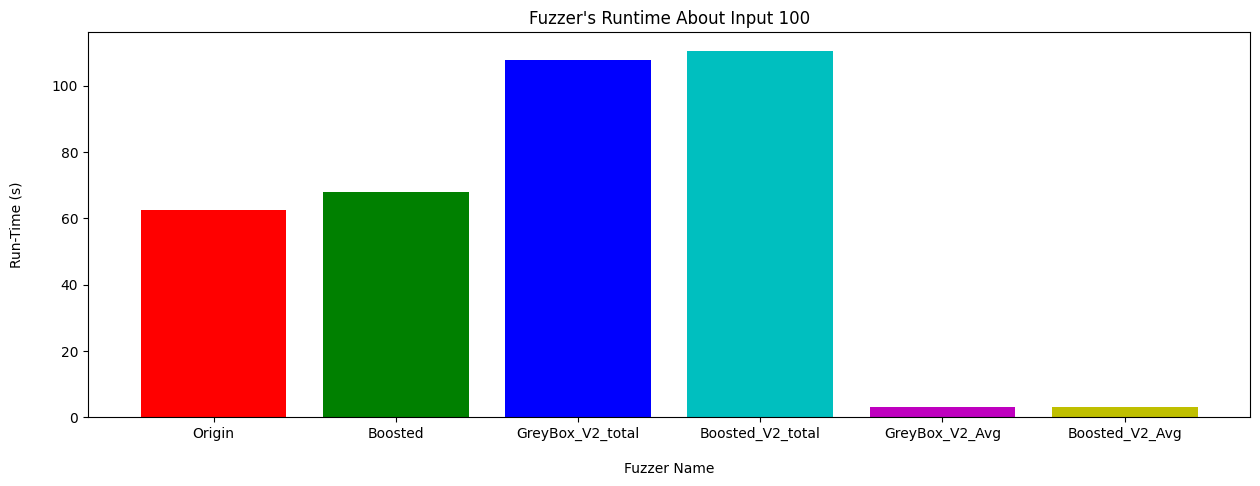

In [ ]:
x = np.arange(6)
fuzzer_nm = ['Origin', 'Boosted',
             'GreyBox_V2_total', 'Boosted_V2_total',
             'GreyBox_V2_Avg' ,'Boosted_V2_Avg']
run_time = [Originc_run_time, boosted_run_time,
            total_time_B, total_time_Boost_V2,
            Base_Greybox_Avg_Time, Boost_Greybox_V2_Avg_Time]
colors = ['r', 'g', 'b', 'c', 'm', 'y']
plt.figure(figsize=(15, 5))
plt.bar(x, run_time, color=colors)
plt.xticks(x, fuzzer_nm)
plt.title("Fuzzer's Runtime About Input "+str(n))
plt.xlabel('Fuzzer Name', labelpad=15)
plt.ylabel('Run-Time (s)', labelpad=20)

plt.show()

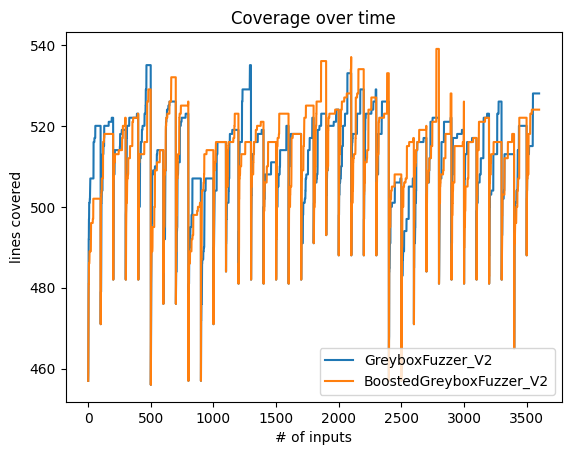

In [ ]:
line_grey_V2, = plt.plot(Base_Greybox_Cov_list, label="GreyboxFuzzer_V2")
line_boost_V2, = plt.plot(Boosted_Greybox_V2_Cov_list, label="BoostedGreyboxFuzzer_V2")

plt.legend(handles=[line_grey_V2, line_boost_V2])

plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

plt.legend(loc='lower right')

plt.show()

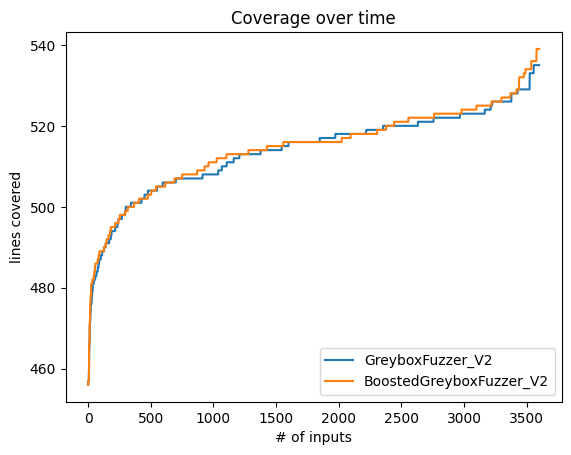

In [ ]:
line_grey_V2, = plt.plot(sorted(Base_Greybox_Cov_list), label="GreyboxFuzzer_V2")
line_boost_V2, = plt.plot(sorted(Boosted_Greybox_V2_Cov_list), label="BoostedGreyboxFuzzer_V2")

plt.legend(handles=[line_grey_V2, line_boost_V2])

plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

plt.legend(loc='lower right')

plt.show()

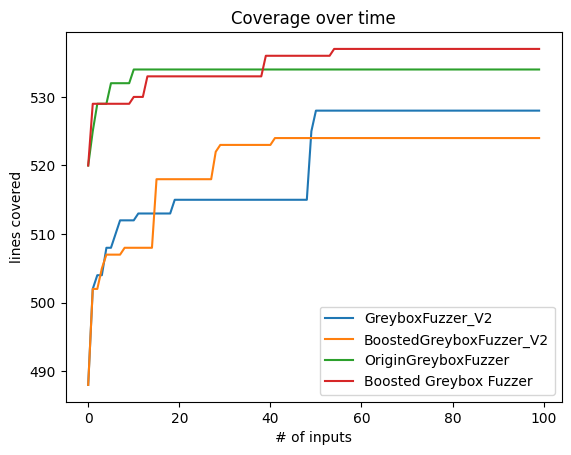

In [ ]:
line_grey_V2, = plt.plot(Base_Greybox_coverage, label="GreyboxFuzzer_V2")
line_boost_V2, = plt.plot(Boosted_Greybox_V2_coverage, label="BoostedGreyboxFuzzer_V2")

line_grey, = plt.plot(Origin_Greybox_coverage, label="OriginGreyboxFuzzer")
line_boost, = plt.plot(Boosted_Greybox_coverage, label="Boosted Greybox Fuzzer")

plt.legend(handles=[line_boost, line_grey, line_grey_V2, line_boost_V2])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');
plt.legend(loc='lower right')

plt.show()

# 추가

In [80]:
with Coverage() as cov:
    my_sql_parser("SELECT * FROM table;")

In [87]:
print(cov.coverage())

{('group_assignment', 183), ('group_tzcasts', 107), ('splitext', 119), ('group_identifier', 225), ('group_aliased', 330), ('match', 184), ('_token_matching', 241), ('from_list', 399), ('format', 420), ('group_operator', 258), ('_get_stack_str', 44), ('getline', 32), ('token_next_by', 265), ('lazycache', 161), ('group_assignment', 196), ('tokenize', 155), ('group_functions', 346), ('group_functions', 355), ('group_typecasts', 83), ('group_as', 166), ('_token_matching', 245), ('<genexpr>', 165), ('_splitext', 139), ('get_default_instance', 50), ('_change_splitlevel', 33), ('group_where', 312), ('from_list', 403), ('checkcache', 64), ('_internal_set_trace', 48), ('_get_stack_str', 39), ('extract', 383), ('flatten', 216), ('line', 306), ('_internal_set_trace', 57), ('format', 433), ('is_keyword', 96), ('group_tzcasts', 97), ('group_functions', 350), ('_token_matching', 240), ('group_typecasts', 87), ('_splitext', 134), ('match', 259), ('process', 96), ('from_list', 398), ('checkcache', 59)